In [2]:
#@title 환경설정

# Hugging Face의 트랜스포머 모델을 설치
!pip install transformers

import sys

from IPython.display import clear_output
clear_output(wait=True)

## 관련 라이브러스 설치
import tensorflow as tf

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

import keras
# from keras.preprocessing.sequence import pad_sequences  # path removed
from keras.utils import pad_sequences

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

clear_output()

print('Python version : ', sys.version)
print('TensorFlow version : ', tf.__version__)
print('Keras version : ', keras.__version__)

Python version :  3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
TensorFlow version :  2.15.0
Keras version :  2.15.0


In [3]:
# pandas import
import pandas as pd

# 파일을 DataFrame으로 전환
df = pd.read_csv('/content/drive/MyDrive/train3.csv')
df

,No.,국가코드,발명의 명칭,요약,독립항,출원인,출원인(원문),발명자,문헌종류 코드,출원번호,...,등록일,존속기간 만료일,전체 IPC,메인 CPC,전체 CPC,인용문헌수,특허인용 수,국가별 특허인용 수,피인용문헌 수,특허피인용 국가
0,1,CN,Pneumatic plate processing device and adjustin...,The present invention relates to the field of ...,[청구항1]\n1. A pneumatic plate processing device...,SHANDONG TIANYI HIGH TECH CO LTD,山?天意高科技有限公司,?强 | ?浩然 | ?洪彬 | ?海? | 董磊 | 李?,A,2024-10361246,...,-,-,"B23B-041/00,[B23Q-011/10, B23Q-011/08, B23Q-00...",-,-,0,0,-,0,-
1,2,CN,A gold-plating device for a ceramic encapsulat...,The invention discloses a gold-plating equipme...,[청구항1]\n1. The gold-plating equipment of the c...,HEFEI ADVANCED PACKAGING CERAM CO LTD,合肥先?封?陶瓷有限公司,?不? | 王? | ?云? | 胡新,A,2024-10361693,...,-,-,"C25D-017/00,[H01L-021/48]",-,-,0,0,-,0,-
2,3,CN,A kind of diamond semiconductor material produ...,The application relates to the technical field...,[청구항1]\n1. A diamond semiconductor material pr...,JIARUIFU DIAMOND HENAN CO LTD,佳睿福?石(河南)有限公司,???,A,2024-10359217,...,-,-,"C22C-026/00,[C22C-001/05, B22F-001/12, B22F-00...",-,-,0,0,-,0,-
3,4,CN,Preparation of high-clean wafer storage and tr...,The invention discloses the preparation of a h...,[청구항1]\n1. The preparation of a high-clean waf...,GUANGDONG MAIJIEWEI NEW MAT CO LTD,???捷微新材料有限公司,袁黔云,A,2024-10359966,...,-,-,"B29C-045/00,[B29B-013/00, B29C-033/72, B29C-03...",-,-,0,0,-,0,-
4,5,CN,The tearing mechanism of the semiconductor aut...,The invention provides a film tearing mechanis...,[청구항1]\n1. The film tearing mechanism of the s...,DONGYI SEMICONDUCTOR TECH JIANGSU CO LTD,?屹半??科技(江?)有限公司,?十逢 | ?子强,A,2024-10288618,...,-,-,B65B-069/00,-,-,0,0,-,0,-
5,6,CN,Automatic substrate peeling machine,The invention discloses a fully automatic subs...,[청구항1]\n1. Fully automatic substrate peeling m...,SHANGHAI JIYAO TECH CO LTD,上海技?科技有限公司,??? | 米?,A,2024-10258549,...,-,-,"B65G-059/04,[B65G-047/91, B65B-069/00]",-,-,0,0,-,0,-
6,7,CN,Wafer transfer control method and transfer con...,The application discloses a wafer transfer con...,[청구항1]\n1. The wafer transfer control method b...,HONGHU SUZHOU SEMICONDUCTOR TECH CO LTD,泓?(?州)半??科技有限公司,林? | 王彭 | ??明 | 王?梁,B,2024-10259080,...,2024.05.03,-,"H01L-021/683,[G06N-003/0464, G06F-030/23, G06F...",-,-,4,4,"CN(3), WO(1)",0,-
7,8,CN,Wafer transfer control method and transfer con...,The application discloses a wafer transfer con...,[청구항1]\n1. The wafer transfer control method b...,HONGHU SUZHOU SEMICONDUCTOR TECH CO LTD,泓?(?州)半??科技有限公司,林? | 王彭 | ??明 | 王?梁,A,2024-10259080,...,2024.05.03,-,"H01L-021/683,[G06F-030/23, G06F-030/27, G06F-0...",-,-,4,4,"CN(3), WO(1)",0,-
8,9,CN,A cerebral perfusion machine for hypothermia t...,The present invention provides a cerebral perf...,[청구항1]\n1. A cerebral perfusion machine for su...,THE FIFTH AFFILIATED HOSPITAL SUN YAT SEN UNIV,中山大?附?第五?院,?慧? | 汪娟 | 李? | 王? | ?洋 | 黎?君 | 周育萍,A,2024-10254676,...,-,-,"A61F-007/12,[A61F-007/00, A61M-001/36]",-,-,0,0,-,0,-
9,10,CN,Laser automatic marking device and marking method,The present invention belongs to the field of ...,[청구항1]\n1. A laser automatic marking device co...,???智能??(无?)有限公司,???智能??(无?)有限公司,??金,A,2024-10247935,...,-,-,"B23K-026/362,[B23K-026/70, B23K-037/04, B23K-1...",-,-,0,0,-,0,-


In [4]:
print(df['label'].groupby(df['label']).count())

label
0    13
1     7
Name: label, dtype: int64


In [5]:
df['label'] = df['label'].apply(pd.to_numeric)

print(df)

    No. 국가코드                                             발명의 명칭  \
0     1   CN  Pneumatic plate processing device and adjustin...   
1     2   CN  A gold-plating device for a ceramic encapsulat...   
2     3   CN  A kind of diamond semiconductor material produ...   
3     4   CN  Preparation of high-clean wafer storage and tr...   
4     5   CN  The tearing mechanism of the semiconductor aut...   
5     6   CN                Automatic substrate peeling machine   
6     7   CN  Wafer transfer control method and transfer con...   
7     8   CN  Wafer transfer control method and transfer con...   
8     9   CN  A cerebral perfusion machine for hypothermia t...   
9    10   CN  Laser automatic marking device and marking method   
10   11   CN                                     Dicing machine   
11   12   CN  Broad-spectrum photosynaptic transistor based ...   
12   13   CN  Spill-proof lamination system for plastic presses   
13   14   CN  Power cycling test system and method for 6000a..

In [6]:
import numpy as np

In [7]:
훈련데이터비율 = 0.8

## 훈련데이터와 테스트데이터로 분리
train=df.sample(frac=훈련데이터비율,random_state=1234)
test=df.drop(train.index)

train.drop_duplicates(subset = ['요약'], inplace=True) # text 열에서 중복인 내용이 있다면 중복 제거
train['요약'] = train['요약'].str.replace("[^a-zA-Z]","") # 정규 표현식 수행
train['요약'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
train = train.dropna(how='any') # Null 값 제거
print('전처리 후 훈련용 샘플의 개수 :',len(train))

test.drop_duplicates(subset = ['요약'], inplace=True) # text 열에서 중복인 내용이 있다면 중복 제거
test['요약'] = test['요약'].str.replace("[^a-zA-Z]","") # 정규 표현식 수행
test['요약'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test = test.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test))

전처리 후 훈련용 샘플의 개수 : 16
전처리 후 테스트용 샘플의 개수 : 4


In [8]:
sentences = train['요약']
print('')
print('##### 원본 데이터 #####')
print(sentences[:10])

# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
print('')
print('##### Bert 형식으로 변환 #####')
print(sentences[:10])


# 라벨 추출
labels = train['label'].values

print('')
print('##### 라벨 추출 #####')
print(labels)


##### 원본 데이터 #####
3     The invention discloses the preparation of a h...
13    The present invention discloses a power cyclin...
2     The application relates to the technical field...
16    The present invention relates to a machine lea...
14    The present invention discloses a terminal pro...
5     The invention discloses a fully automatic subs...
4     The invention provides a film tearing mechanis...
0     The present invention relates to the field of ...
8     The present invention provides a cerebral perf...
18    The invention discloses a semiconductor device...
Name: 요약, dtype: object

##### Bert 형식으로 변환 #####
['[CLS] The invention discloses the preparation of a high-clean wafer storage and transportation box, and the preparation method is as follows: step 1: raw material selection; Step 2: Baking material: temporarily store the material in a clean stainless steel barrel with a sealed lid, clean the drying barrel, bake the material, and remove the organic matter with high b

In [9]:
from transformers import BertTokenizer

In [10]:
bert모델 = 'bert-base-multilingual-cased'

#"bert-base-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json"
#"bert-large-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-config.json",
#"bert-base-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json",
#"bert-large-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-config.json",
#"bert-base-multilingual-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json",
#"bert-base-multilingual-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json",
#"bert-base-chinese": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-config.json",
#"bert-base-german-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-cased-config.json",
#"bert-large-uncased-whole-word-masking": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-config.json",
#"bert-large-cased-whole-word-masking": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-config.json",
#"bert-large-uncased-whole-word-masking-finetuned-squad": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-finetuned-squad-config.json",
#"bert-large-cased-whole-word-masking-finetuned-squad": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-finetuned-squad-config.json",
#"bert-base-cased-finetuned-mrpc": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-finetuned-mrpc-config.json",
#"bert-base-german-dbmdz-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-dbmdz-cased-config.json",
#"bert-base-german-dbmdz-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-dbmdz-uncased-config.json",
#"bert-base-japanese": "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-config.json",
#"bert-base-japanese-whole-word-masking": "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-whole-word-masking-config.json",
#"bert-base-japanese-char": "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-char-config.json",
#"bert-base-japanese-char-whole-word-masking": "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-char-whole-word-masking-config.json",
#"bert-base-finnish-cased-v1": "https://s3.amazonaws.com/models.huggingface.co/bert/TurkuNLP/bert-base-finnish-cased-v1/config.json",
#"bert-base-finnish-uncased-v1": "https://s3.amazonaws.com/models.huggingface.co/bert/TurkuNLP/bert-base-finnish-uncased-v1/config.json",


# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained(bert모델, do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

[CLS] The invention discloses the preparation of a high-clean wafer storage and transportation box, and the preparation method is as follows: step 1: raw material selection; Step 2: Baking material: temporarily store the material in a clean stainless steel barrel with a sealed lid, clean the drying barrel, bake the material, and remove the organic matter with high boiling point; Step 3: Injection molding: production of leftover materials before cleaning, use V5 material to clean the machine 3 times the capacity of the material tube / V5 special screw, the mold needs to be thoroughly cleaned offline and then 10PCS product molding and cleaning on the machine, clean with high-purity anhydrous alcohol to prevent the cleaning agent from reacting with the material, injection molding is an independent molding environment, the injection time of the lower shell needs to be before the shell or at the same time, injection molding workshop 3, independent molding to prevent the material from reacti

문장의 최대 길이 : 1475
문장의 평균 길이 : 1199.4375


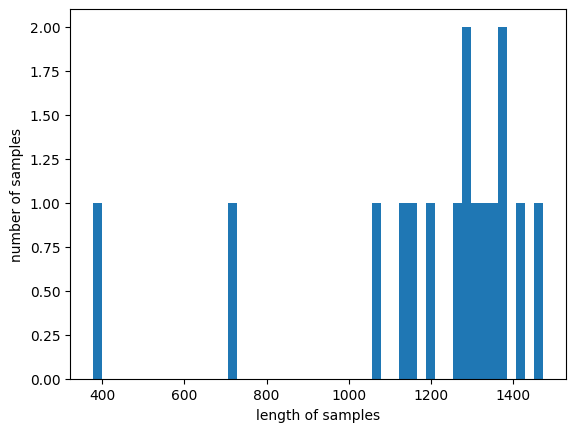

전체 샘플 중 길이가 1475 이하인 샘플의 비율: 100.0


In [11]:
## 전처리를 위한 기본 텍스트 정보를 탐색합니다.

최대길이 = int(max(len(l) for l in sentences))

print('문장의 최대 길이 :',max(len(l) for l in sentences))
## 문장의 최대 길이는 가장 긴 문장의 길이를 의미합니다.

print('문장의 평균 길이 :',sum(map(len, sentences))/len(sentences))
## 문장의 평균 길이는 문장 길이의 평균값을 의미합니다.

import matplotlib.pyplot as plt

plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 문장 길이 전체 그래프를 살펴보면, 문장의 전체 분포를 볼 수 있습니다.
## 대다수의 문장이 50자 이하인 것을 알 수 있습니다.


def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))


max_len = 최대길이
below_threshold_len(max_len, sentences)

## max_leb(문장 최대 길이)가 128일때 선택되는 전체 데이터량을 의미합니다.
## 현재값은 95.92로 대략 6%를 제외한 모든 데이터가 선택된 것을 확인할 수 있습니다.

In [12]:
from keras.utils import pad_sequences

In [13]:
# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 최대길이

## 입력 문장의 최대 길이를 지정해줍니다.
## 물론 어떤 리뷰는 128자 이상이기도 합니다. 하지만 효율성을 위해서 고정해줍니다.
## MAX_LEN을 256, 512 등 더 크게 변경할 수도 있습니다. 그러면 처리 시간이 더 걸립니다. 대신 정확도는 상승합니다.
## 반대로 MAX_LEN을 64, 32 등 더 작게 변경할 수도 있습니다. 그러면 처리 시간은 짦아지고, 정확도는 줄어듭니다.
## MAX_LEN에 "정답"은 없습니다. 적절한 길이를 선택해야 합니다.

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
## 패딩이란 MAX_LEN보다 짦은 문장에 적용합니다. 문장 길이가 120이라면 8개가 패딩으로 채워지게 됩니다.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

print(input_ids[0])

# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[  101 10117 66626 ...     0     0     0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
검증데이터비율 = "0.3"

배치크기 = "64"
배치크기 = int(배치크기)


# 훈련셋과 검증셋으로 분리
validation_size = 검증데이터비율
## 훈련셋과 검증셋은 9:1로 분리해줍니다. 숫자를 변경하면 비율을 변경할 수 있습니다.

random_state = 1234
## 컴퓨터에서의 분리는 시간값을 토대로 하는 랜덤입니다.
## 하지만 완전히 랜덤으로 하면 학습마다 다른 결과가 나오는 문제가 발생합니다.
## 이를 통제하기 위해서 랜덤 시작값을 세팅해줍니다.

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels,
                                                                                    random_state=random_state,
                                                                                    test_size=0.1)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks,
                                                       input_ids,
                                                       random_state=random_state,
                                                       test_size=0.1)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

print("##### 훈련 텍스트의 bert embedding값 #####")
print(train_inputs[0])
print("##### 훈련 텍스트의 label 값 #####")
print(train_labels[0])
print("##### 훈련 텍스트의 MASK값 = 패딩 여부 확인 #####")
print(train_masks[0])
print("##### 검증 텍스트의 bert embedding값 #####")
print(validation_inputs[0])
print("##### 검증 텍스트의 label 값 #####")
print(validation_labels[0])
print("##### 검증 텍스트의 MASK값 = 패딩 여부 확인 #####")
print(validation_masks[0])


# 배치 사이즈
batch_size = 배치크기

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

##### 훈련 텍스트의 bert embedding값 #####
tensor([  101, 10117, 66626,  ...,     0,     0,     0])
##### 훈련 텍스트의 label 값 #####
tensor(0)
##### 훈련 텍스트의 MASK값 = 패딩 여부 확인 #####
tensor([1., 1., 1.,  ..., 0., 0., 0.])
##### 검증 텍스트의 bert embedding값 #####
tensor([  101, 10117, 12254,  ...,     0,     0,     0])
##### 검증 텍스트의 label 값 #####
tensor(1)
##### 검증 텍스트의 MASK값 = 패딩 여부 확인 #####
tensor([1., 1., 1.,  ..., 0., 0., 0.])


In [16]:
# 리뷰 문장 추출
sentences = test['요약']

# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]

# 라벨 추출
labels = test['label'].values

# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained(bert모델, do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=최대길이, dtype="long", truncating="post", padding="post")

# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

# 데이터를 파이토치의 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=배치크기)

In [17]:
# 해당 부분에서 에러가 나면, "런타임 > 런타임 유형 변경 > 하드웨어 가속시 > GPU"로 변경해야 합니다.

# GPU 디바이스 이름 구함
device_name = tf.test.gpu_device_name()

# GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# 디바이스 설정
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [18]:
# 분류를 위한 BERT 모델 생성
## 이미 bert를 통한 분류 모델이 만들어져 있습니다. 모델을 불러오기만 하면 됩니다.
## num_labels를 통해서 분류 갯수를 지정해줍니다. 저희는 긍정-부정의 2개 분류이기에 2입니다.

분류개수 = "2"
분류개수 = int(분류개수)

epochs수 = "10"
epochs수 = int(epochs수)

model = BertForSequenceClassification.from_pretrained(bert모델, num_labels=분류개수)
model.cuda()

# 옵티마이저 설정
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = epochs수

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

In [20]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):

    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))

    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))


## 본격적으로 딥러닝 학습을 수행하게 됩니다.
## 현재 150000개의 데이터로는 1 epoch 50분 정도의 시간이 소요됩니다.
## 4번의 epoch이기에 약 200분, 3시간이 넘는 학습 시간이 필요합니다.
## 연습을 하실 때에는 1000개 정도로 데이터량을 줄여서 테스트 해보실 것을 권장드립니다.

from tqdm.notebook import tqdm

# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# 에폭만큼 반복
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # 훈련모드로 변경
    model.train()

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시 / 매 40  batch 마다
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        # 그래디언트 초기화
        model.zero_grad()

        # Forward 수행
        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        # 총 로스 계산
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        loss = output[0]
        total_train_loss += loss.item()
        logits = output[1]

        # Backward 수행으로 그래디언트 계산
        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # 그래디언트 클리핑
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # 스케줄러로 학습률 감소
        # Update the learning rate.
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss  / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 그래디언트 계산 안함
        with torch.no_grad():
            # Forward 수행
            output = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        # 로스 구함
        loss = output.loss
        total_eval_loss += loss.item()
        logits = output.logits

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 출력 로짓과 라벨을 비교하여 정확도 계산
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training. Accur': avg_val_accuracy,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...


RuntimeError: The expanded size of the tensor (1475) must match the existing size (512) at non-singleton dimension 1.  Target sizes: [14, 1475].  Tensor sizes: [1, 512]

In [ ]:
import pandas as pd

# Display floats with two decimal places.
# pd.set_option('precision', 2)  # deprecated
pd.set_option("display.max_columns", 100)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
print(df_stats.to_string())


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# plt.xticks([1, 2, 3, 4])
plt.xticks([i for i in range(1, epochs수+1)])

plt.show()

KeyError: "None of ['epoch'] are in the columns"


##### 테스트 모델을 통한 모델 정확도 #####
Accuracy: 0.75
Test took: 0:00:00

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.00      0.00      0.00         0

    accuracy                           0.75         4
   macro avg       0.50      0.38      0.43         4
weighted avg       1.00      0.75      0.86         4




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-21-f7049e0e30a5>:135: RuntimeWarning: invalid value encountered in divide

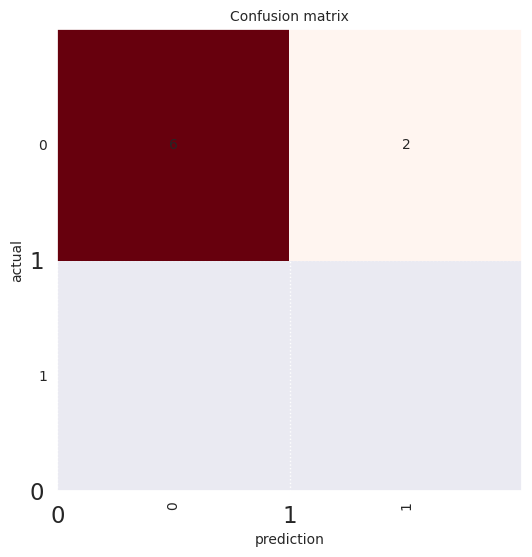

In [ ]:
라벨링 = ['0','1']


# import
import time

#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()


# Tracking variables
predictions , true_labels, predictionsfin = [], [], []

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch

    # 그래디언트 계산 안함
    with torch.no_grad():
        # Forward 수행
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("##### 테스트 모델을 통한 모델 정확도 #####")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))


## 테스트 데이터를 대상으로 하는 모델 상세 평가
## precision = 정밀도 = 실제로는 False이지만 True로 라벨링 한 것에 집중
## 실제로는 스팸메일이 아니지만 스펨 메일로 라벨링하면?!
## recall = 재현율 = 실제 True인데 False 라벨링한 것에 집중
## 실제로는 코로나 감염자이지만, 코로나 감염이 아니라고 하면?!
## F1 = 정밀도와 재현율의 조화평균

rounded_labels_set = []
rounded_predictions_set = []

from sklearn.metrics import classification_report

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  rounded_labels = np.argmax(predictions[i], axis=1).flatten()
  rounded_labels_set.extend(rounded_labels)
  # Calculate and store the coef for this batch.
  rounded_predictions = true_labels[i].flatten()
  rounded_predictions_set.extend(rounded_predictions)

labels = 라벨링

print("")
print(classification_report(rounded_labels_set, rounded_predictions_set, target_names=labels))
print("")


## 혼란 매트릭스 - Confusion matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  rounded_labels = np.argmax(predictions[i], axis=1).flatten()
  rounded_labels_set.extend(rounded_labels)
  # Calculate and store the coef for this batch.
  rounded_predictions = true_labels[i].flatten()
  rounded_predictions_set.extend(rounded_predictions)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels_set, rounded_predictions_set)

def plot_confusion_matrix(
    ax, matrix, labels, title='Confusion matrix', fontsize=9):

    ax.set_xticks([x for x in range(len(labels))])
    ax.set_yticks([y for y in range(len(labels))])

    # Place labels on minor ticks
    ax.set_xticks([x + 0.5 for x in range(len(labels))], minor=True)
    ax.set_xticklabels(labels, rotation=90, fontsize=fontsize, minor=True)  # rotation must be num not str
    ax.set_yticks([y + 0.5 for y in range(len(labels))], minor=True)
    ax.set_yticklabels(labels[::-1], fontsize=fontsize, minor=True)

    # Hide major tick labels
    ax.tick_params(which='major', labelbottom='off', labelleft='off')

    # Finally, hide minor tick marks
    ax.tick_params(which='minor', width=0)

    # Plot heat map
    proportions = [1. * row / sum(row) for row in matrix]
    ax.pcolor(np.array(proportions[::-1]), cmap=plt.cm.Reds)

    # Plot counts as text
    for row in range(len(matrix)):
        for col in range(len(matrix[row])):
            confusion = matrix[::-1][row][col]
            if confusion != 0:
                ax.text(col + 0.5, row + 0.5, int(confusion),
                        fontsize=fontsize,
                        horizontalalignment='center',
                        verticalalignment='center')

    # Add finishing touches
    ax.grid(True, linestyle=':')
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel('prediction', fontsize=fontsize)
    ax.set_ylabel('actual', fontsize=fontsize)

    plt.show()


if __name__ == '__main__':
    matrix = cm
    labels = 라벨링

    fig, ax = plt.subplots(figsize=(6, 6))

    plot_confusion_matrix(ax, matrix, labels, fontsize=10)

In [ ]:
테스트용텍스트 = 'The invention discloses a laser material level instrument and a using method thereof. The laser material level instrument comprises a shell, wherein the shell comprises an upper protective shell, a main body and a locking protruding block, the main body comprises an upper cover covering the top of the main body, a first transparent part is fixedly arranged at a top end in the upper cover, and a large pressing ring is installed at the position, at the bottom of the first transparent part, of the top of the main body; a rubber pad is arranged between the large pressing ring and the first transparent part, the structure of an existing product is designed to be integrally cast and formed, the original material is cast aluminum, a sliding part and a spring part are removed, unnecessary connecting parts are reduced, product assembling precision is improved, and after one-time mold opening cost is paid, production cost can be greatly reduced through structure later-period purchase; the structure is simple, an L-shaped stainless steel plate is adopted inside, machining is completed through a machining center, convenience is achieved, operation is easy, the semiconductor laser is fixed, no sliding block or spring exists, assembling efficiency and assembling precision are improved, and cost is reduced.'  #@param {type: "string"}

# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 1475

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)

    # 그래디언트 계산 안함
    with torch.no_grad():
        # Forward 수행
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

logits = test_sentences([테스트용텍스트])

print(logits)
print(np.argmax(logits))

[[ 0.42107153 -0.4178504 ]]
0


In [ ]:
model.save_pretrained('.')

## 딥러닝 모델 저장하기
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

!cp "/content/pytorch_model.bin" -r "/content/drive/MyDrive"
!cp "/content/config.json" -r "/content/drive/MyDrive"

Mounted at /content/drive


In [ ]:
# 문서 ID로 실제 파일 불러오는 법
# pytorch_model.bin 링크 기입
## https://drive.google.com/file/d/1WlA1H9zlXyYFqrW0Yt1MsYKhCoW1ss8t/
파일ID = 'https://drive.google.com/file/d/1cQVhjUQY0Ye6f4PUY96bZiUM4pozhDZ3/'
파일저장이름 = 'pytorch_model.bin'

!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1cQVhjUQY0Ye6f4PUY96bZiUM4pozhDZ3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1cQVhjUQY0Ye6f4PUY96bZiUM4pozhDZ3" -O pytorch_model.bin && rm -rf ~/cookies.txt


# config.json 링크 기입
## https://drive.google.com/file/d/1tus80Qm7dUDK-Mut_kEknxFCYZTWmCMy/
파일ID = 'https://drive.google.com/file/d/1-A0Iv_6WGjrdWAsAip4h4vfWZpjfMZB4/'
파일저장이름 = 'config.json'

!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-A0Iv_6WGjrdWAsAip4h4vfWZpjfMZB4' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-A0Iv_6WGjrdWAsAip4h4vfWZpjfMZB4" -O config.json && rm -rf ~/cookies.txt

--2024-05-19 13:08:53--  https://docs.google.com/uc?export=download&confirm=&id=1cQVhjUQY0Ye6f4PUY96bZiUM4pozhDZ3
Resolving docs.google.com (docs.google.com)... 74.125.142.100, 74.125.142.102, 74.125.142.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1cQVhjUQY0Ye6f4PUY96bZiUM4pozhDZ3&export=download [following]
--2024-05-19 13:08:54--  https://drive.usercontent.google.com/download?id=1cQVhjUQY0Ye6f4PUY96bZiUM4pozhDZ3&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.117.132, 2607:f8b0:400e:c0a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.117.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 0 [application/octet-stream]
Saving to: ‘pytorch_model.bin’

pytorch_model.bin       [ <=>                ]       0  --.-KB/s    